In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from ipynb_util import *
from lightprop2d import Beam2D, random_round_hole_phase, um, round_hole, gaussian_beam, plane_wave

### Загрузка данных о волокнах
Загружаются рассчитанные ранее данные в трех словарях, ключи которых -- радиус кривизны волокна `c` (для прямого волокна 0):
1. `modes[c]` -- массив профилей поля мод, распространяющихся по волокну. Тип `numpy.array`
2. `betas[c]` -- массив констант распространения мод. Константы отсортированы по убыванию модуля. Тип `numpy.array`
3. `ops[c]` -- оператор эволюции поля в волокне. Тип `scipy.sparse.csc_matrix`

Аргументы функции -- общая маска файлов, `dir` -- относительный или абсолютный путь к папке с файлами

In [3]:
modes, betas, ops = load_fiber_data('mmf_GRIN_62.5_*.npz', dir='data')

### Пример расчета входных и выходных полей
Алгоритм:
1. Строится объект для двухмерного поперечного поля `Beam2D` по массиву значений поля (аргумент `init_field`) или спектра (аргумент `init_spectrum`). Также можно построить с помощью функции, задающей поле: объект функции`init_field_gen`, аргументы функции -- в `tuple` `init_gen_args`, при этом функция должна иметь интерфейс `func(X, Y, *args)`, где `X,Y` -- одномерные массивы координат, `X` -- строка, `Y` -- столбец, `*args` -- параметры функций. Много примеров представлено в `lightprop2d.profiles`, к примеру
   ```python
   def random_round_hole(x: Union[np.ndarray, cp.ndarray],
                      y: Union[np.ndarray, cp.ndarray],
                      R: float, x0: float = 0, y0: float = 0,
                      binning_order: int = 1
                      ) -> Union['np.ndarray[Any]', 'cp.ndarray[Any]']:
    field = random_wave(x, y, binning_order)
    field[round_hole(x, y, R, x0, y0) == 0] = 0
    return field
    ```
2. Для всех радиусов кривизны в функции `ipynb_util.calc_inout` рассчитываются следующие характеристики:
   1. Комплексная амплитуда поля на входе волокна после разложения по распространяющимся модам
   2. Комплексная спектральная амплитуда поля на входе волокна после разложения по распространяющимся модам
   3. Комплексная амплитуда поля на выходе волокна
   4. Комплексная спектральная амплитуда поля на выходе волокна
   5. Модовые коэффициенты разложения поля на входе волокна
   6. Модовые коэффициенты разложения поля на выходе волокна
   
   Эти характеристики объединены в `tuple`

In [19]:
wl = 0.632  # Длина волны в мкм
radius = 31.25  # Радиус волокна в мкм
n1 = 1.45

area_size = 3.5 * radius # Размер области счета в мкм. Область расчета квадратная
npoints = 2**8  # Разрешение по одной из осей. Область расчета квадратная
fiber_len = 100 / um # Длина волокна для расчета в мкм. Вводится в см, потом преобразуется в мкм (ограничение библиотеки)

# Использование CUDA. Если не стоит cupy 11.0 и выше, то работать не будет, скорее всего. Для единичных расчетов без кеширования, как здесь, смысла включать особого нет
# На моем компьютере с включенным GPU расчет идет 44.5с, с выключенным 48.1с
USE_GPU = False

ref = Beam2D(area_size, npoints, wl,
             init_field_gen=random_round_hole_phase,
             init_gen_args=(radius,), use_gpu=USE_GPU,
             complex_bits=64)

data = {}
for c in modes:
    data[c] = calc_inout(modes[c], ops[c], ref, fiber_len, use_gpu=USE_GPU)

### Построение графиков для рассчитанных характеристик
Для рассчитанных характеристик можно построить полезные графики с помощью функции `ipynb_util.plot_inout_data`. Строится амплитуда и фаза поля, спектральная амплитуда и фаза на входе и выходе из волокна.

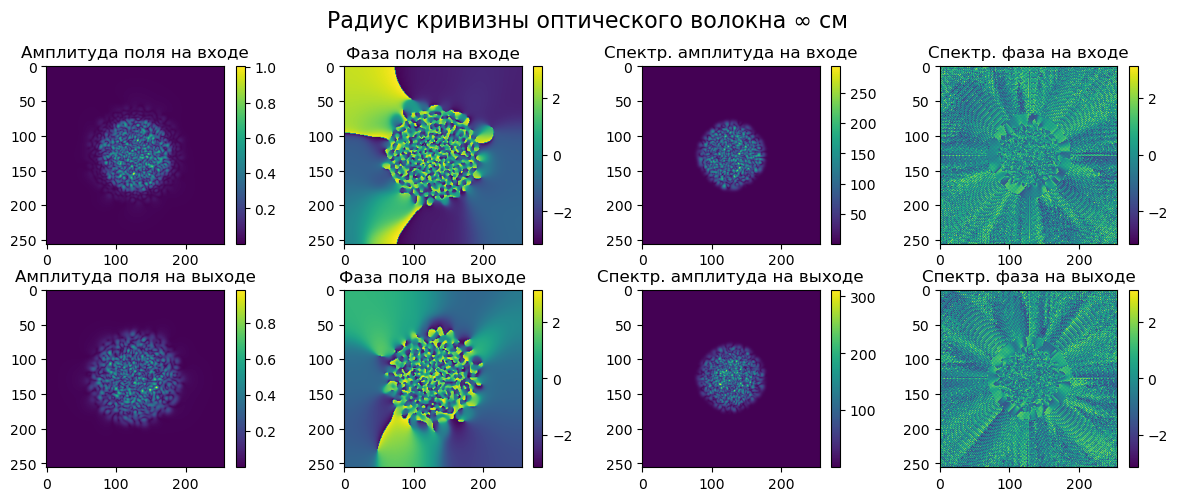

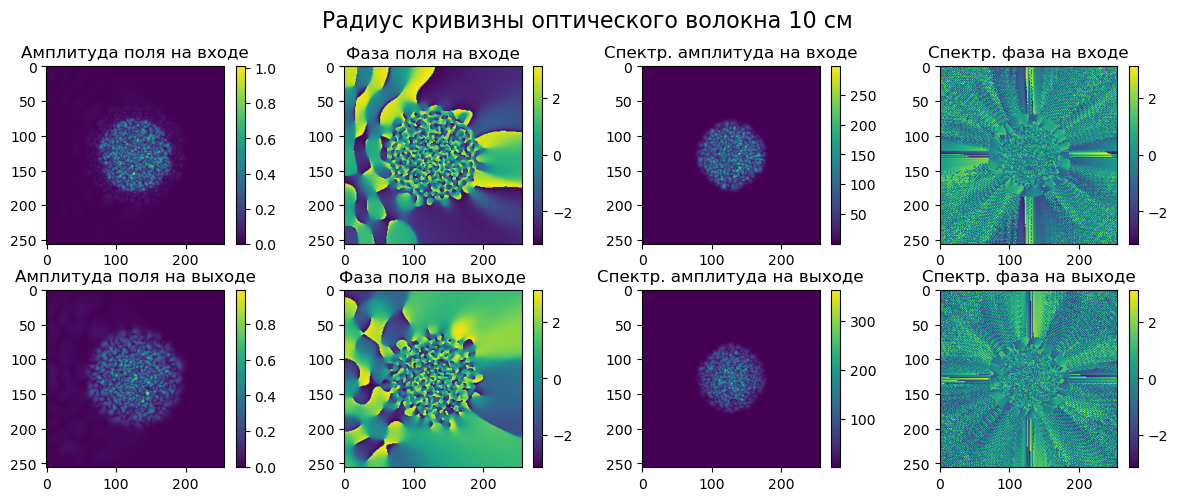

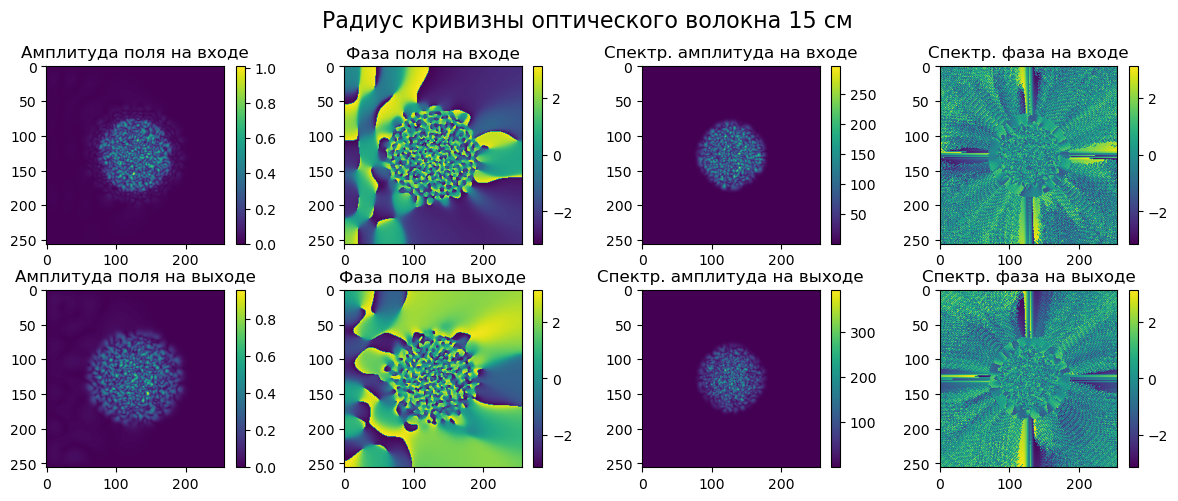

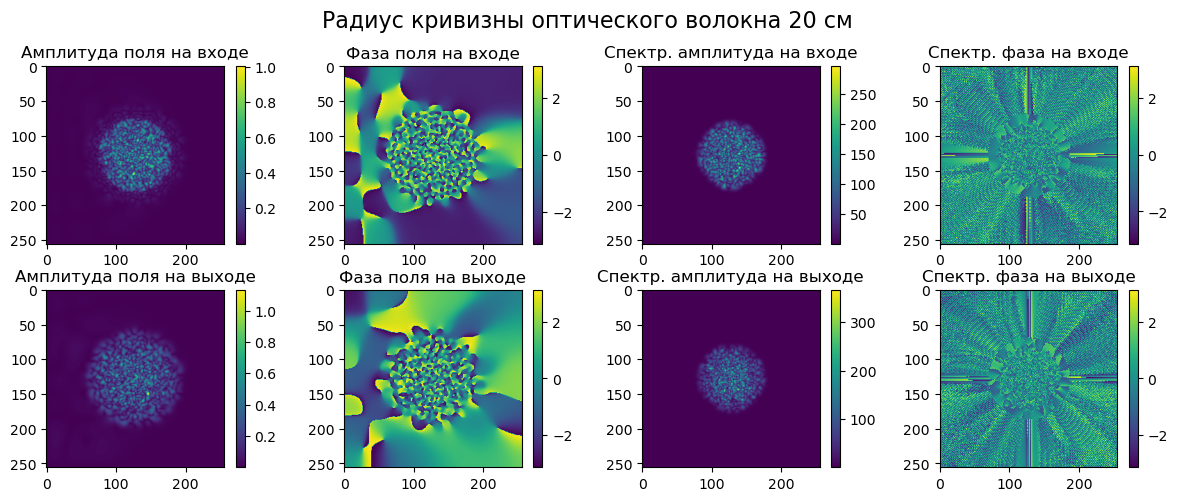

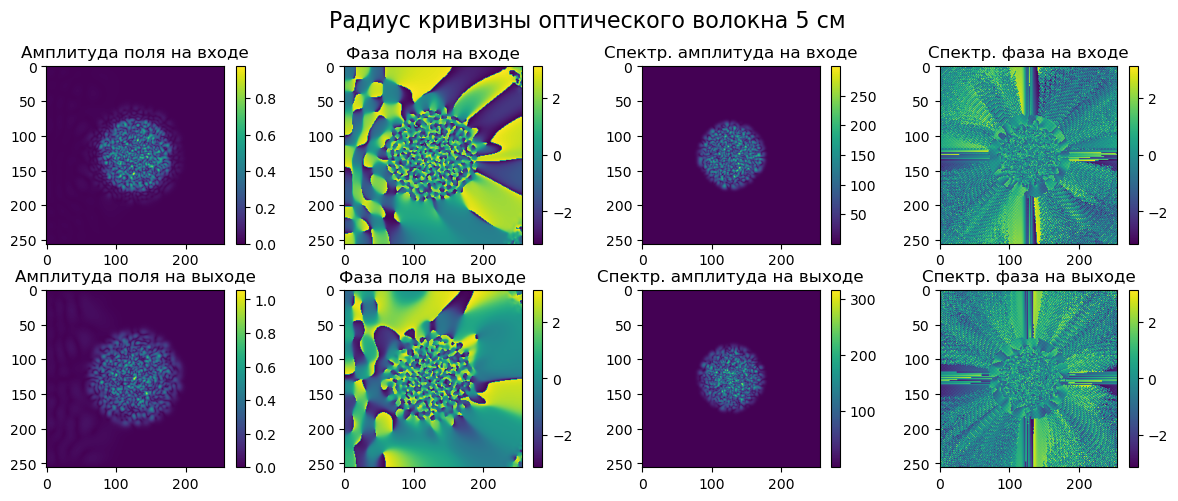

In [15]:
for c in data:
    plot_inout_data(data[c], c)